In [1]:
!pip install labelme opencv-python albumentations

- labelme allows to do annotations
- tensorflow for Deep Learning
- matplotlib for rendering images
- albumentations for data augmentations by Bounding Box Augmentations

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

Collect Images

In [4]:
capture = cv2.VideoCapture(0)
#time.sleep(3)
number_images = 1
for imgnum in range(number_images):
    print('Collecting Image - '.format(imgnum))
    ret, frame = capture.read()
    if not ret:
        print('Error capturing video frame')
        break
    imgname=os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
capture.release()
cv2.destroyAllWindows()

In [5]:
#image shape - dimensionalities
print(frame.shape)

(480, 640, 3)


In [6]:
!labelme

Analyze Datasets 

In [7]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# limit the gpu memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[]

In [10]:
# load images into TF Data Pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [11]:
images.as_numpy_iterator().next()

b'data\\images\\000bb4d5-eb1e-11ed-af06-30d16be1dbf8.jpg'

In [12]:
# Image loading
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_images)

In [14]:
images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 72,  76,  51],
        [ 71,  76,  44],
        [ 71,  77,  43]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 72,  76,  51],
        [ 72,  77,  47],
        [ 72,  78,  44]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 73,  77,  54],
        [ 73,  77,  50],
        [ 73,  78,  46]],

       ...,

       [[  7,  10,   3],
        [  6,   9,   2],
        [  6,   9,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  5,   7,   2],
        [  5,   7,   2],
        [  5,   7,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  5,   7,   2],
        [  6,   8,   3],
        [  6,   8,   3],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

<b>Visualize Images</b>

In [15]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [16]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

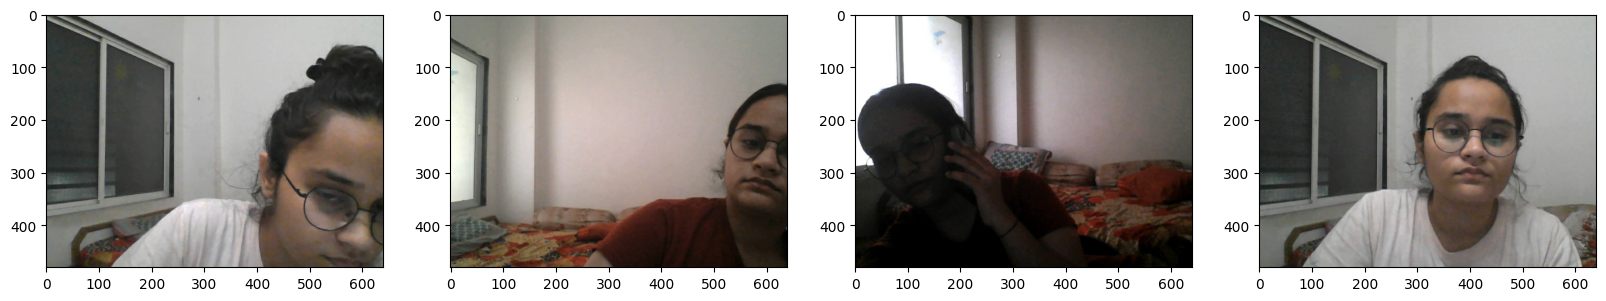

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

running above cell will iterate throughout the images. <br>
i.e, Will get next images at every iteration.

<b>Partition Unaugmented Data</b><br>
MANUAL PROCESS to split data to training, testing and validation

In [28]:
print("Train Data - ",151*0.7) #21
print("Test Data - ",151*0.15) #18 test 18 val 4 5

Train Data -  105.69999999999999
Test Data -  22.65


In [29]:
# moving their labels to the directories
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

<b>Image Augmentations on Images and Labels using Albumentations</b>

In [30]:
import albumentations as alb

Different formats for BboxParams - 
- albumentations
- pascal_voc
- coco
- yolo

In [31]:
# Applying 6 augmentations
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format='albumentations', label_fields =['class_labels']))

Load Test image and annote it with OpenCV and JSON

In [32]:
img = cv2.imread(os.path.join('data','train','images','ed0c8258-eb13-11ed-9192-30d16be1dbf8.jpg'))
img #returns none that means it is not in train folder else return image value 

In [35]:
img = cv2.imread(os.path.join('data','train','images','1f88bfa4-eb14-11ed-bc09-30d16be1dbf8.jpg'))
img

array([[[119, 123, 118],
        [118, 122, 117],
        [118, 122, 117],
        ...,
        [124, 131, 128],
        [121, 130, 127],
        [121, 130, 127]],

       [[119, 123, 118],
        [119, 123, 118],
        [119, 123, 118],
        ...,
        [123, 130, 127],
        [120, 129, 126],
        [119, 128, 125]],

       [[116, 122, 117],
        [116, 122, 117],
        [119, 122, 120],
        ...,
        [122, 129, 126],
        [121, 128, 125],
        [120, 127, 124]],

       ...,

       [[ 53,  80,  90],
        [ 65,  94, 103],
        [ 71, 100, 109],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 45,  62,  71],
        [ 62,  81,  89],
        [ 68,  91,  99],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 42,  53,  61],
        [ 46,  62,  69],
        [ 41,  60,  68],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [36]:
with open(os.path.join('data','train','labels','1f88bfa4-eb14-11ed-bc09-30d16be1dbf8.json'),'r') as f:
    label = json.load(f)

In [37]:
# for the above img
print(type(label))
print(label['shapes'])
print(label['shapes'][0]['label'])
label 

<class 'dict'>
[{'label': 'face', 'points': [[558.013698630137, 242.73972602739724], [639.0, 420.77572738593915]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}}]
face


{'version': '5.2.0.post4',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[558.013698630137, 242.73972602739724],
    [639.0, 420.77572738593915]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\1f88bfa4-eb14-11ed-bc09-30d16be1dbf8.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpK

- Extract Coordinates and rescale to Match Image Resolution

In [38]:
# of the above image
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [39]:
coords

[558.013698630137, 242.73972602739724, 639.0, 420.77572738593915]

In [40]:
# divide(width, height, width, height)
coords = list(np.divide(coords,[640,480,640,480]))
coords

[0.8718964041095891, 0.5057077625570776, 0.9984375, 0.8766160987207066]

<b>Apply Augmentation</b>

In [41]:
augmented = augmentor(image = img, bboxes=[coords], class_labels=['face'])

In [42]:
print(type(augmented))
augmented

<class 'dict'>


{'image': array([[[ 99,  90,  99],
         [ 99,  88, 100],
         [ 99,  88, 100],
         ...,
         [ 96,  88, 105],
         [ 97,  87, 104],
         [ 97,  87, 104]],
 
        [[ 99,  90,  99],
         [ 99,  88, 100],
         [ 99,  88, 100],
         ...,
         [ 97,  88, 101],
         [ 97,  88, 101],
         [ 97,  87, 104]],
 
        [[ 97,  88, 100],
         [ 97,  88, 100],
         [ 97,  88, 100],
         ...,
         [100,  90, 101],
         [100,  90, 101],
         [ 97,  88, 101]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 39,  41,  78],
         [ 37,  39,  76],
         [ 42,  46,  85]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 35,  43,  82],
         [ 35,  43,  82],
         [ 38,  47,  85]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 13,  24,

In [43]:
augmented['class_labels']

['face']

In [44]:
augmented['bboxes']

[(0.0, 0.4994216133942161, 0.07774733637747333, 0.8950571719687537)]

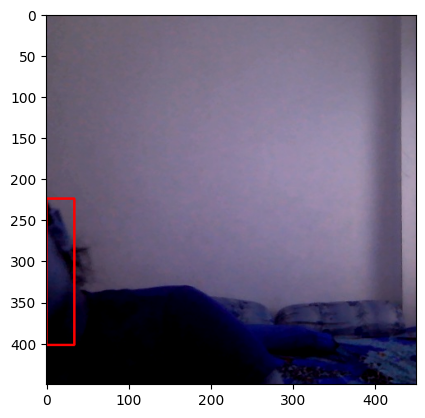

In [45]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

<b>Run Augmentation Pipeline for all the images</b>

In [46]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [47]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) # compress image
train_images = train_images.map(lambda x: x/255)

In [48]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120))) # compress image
test_images = test_images.map(lambda x: x/255)

In [49]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120))) # compress image
val_images = val_images.map(lambda x: x/255)

In [50]:
train_images.as_numpy_iterator().next()

array([[[0.6612132 , 0.6685049 , 0.62395835],
        [0.66243875, 0.6663603 , 0.63596815],
        [0.6617647 , 0.6627451 , 0.6431373 ],
        ...,
        [0.547549  , 0.5593137 , 0.51911765],
        [0.54246324, 0.55422795, 0.5257966 ],
        [0.54748774, 0.5641544 , 0.54405636]],

       [[0.6661765 , 0.6632353 , 0.64362746],
        [0.6666054 , 0.6670956 , 0.63572305],
        [0.6627451 , 0.6637255 , 0.6308824 ],
        ...,
        [0.54601717, 0.5577819 , 0.52346814],
        [0.5525122 , 0.56427693, 0.53682595],
        [0.5509804 , 0.5602941 , 0.5377451 ]],

       [[0.65882355, 0.6666667 , 0.6519608 ],
        [0.6627451 , 0.6745098 , 0.6460784 ],
        [0.6622549 , 0.67401963, 0.6317402 ],
        ...,
        [0.5480392 , 0.5598039 , 0.5323529 ],
        [0.5446078 , 0.5563725 , 0.52892154],
        [0.55134803, 0.5606618 , 0.53811276]],

       ...,

       [[0.25490198, 0.20245098, 0.16715686],
        [0.27340686, 0.19840686, 0.17438726],
        [0.2927696 , 0

<h1>Prepare Labels</h1>
<br>
<b>Loading labels</b>

In [51]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

<b>Load labels to tensorflow Dataset</b>

In [52]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.261 , 0.2101, 0.8135], dtype=float16))

<h1>Combine labels and images</h1>
<br>
<b>check partition lengths</b>

In [56]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6360, 6360, 1380, 1380, 1320, 1320)

<b>Create final dataset [merged = images + labels]</b>

In [57]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [60]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.5674, 0.2423, 0.9907, 0.7324],
        [0.1722, 0.2126, 0.614 , 0.7437],
        [0.    , 0.1771, 0.3577, 0.7124],
        [0.0846, 0.2058, 0.5884, 0.7627],
        [0.    , 0.3635, 0.3125, 1.    ],
        [0.    , 0.2299, 0.2705, 0.7627],
        [0.    , 0.    , 0.    , 0.    ],
        [0.254 , 0.195 , 0.758 , 0.752 ]], dtype=float16))

<b>View Images and Annotations</b>

In [61]:
data_samples = train.as_numpy_iterator()

In [64]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


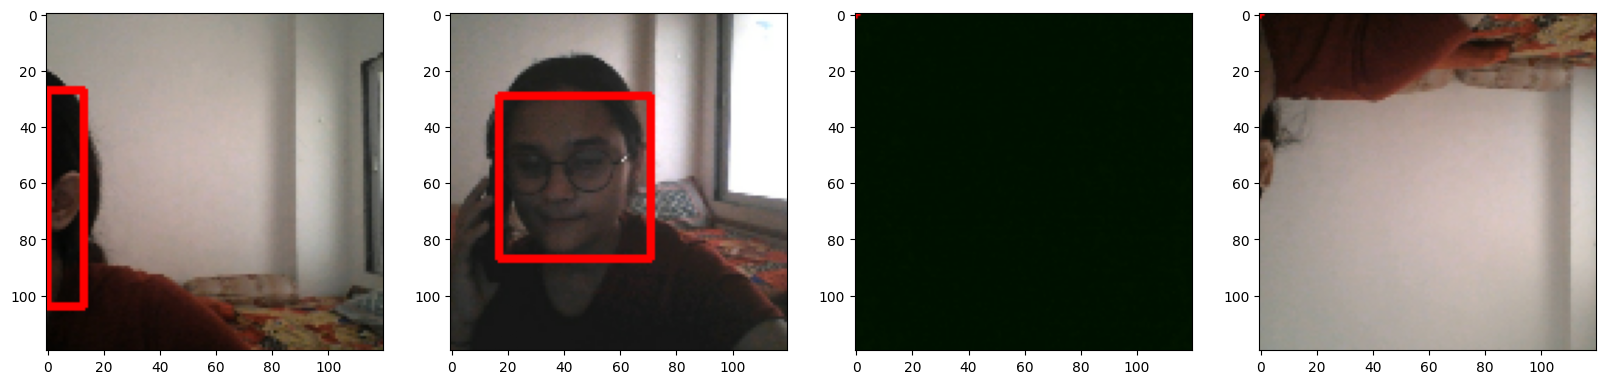

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

<b>Completed data preprocessing</b>

<h1>Build and Train Model</h1>
<br>
1. Detect face - Binary Classification
2. Find out face co-ordinates - Regression 

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

<b>Download VGG16</b>

In [67]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 17s 0us/step


In [68]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<b>Build instance of Network</b>

In [69]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

<b>Test Neural Network</b>

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [72]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [73]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [74]:
classes, coords

(array([[0.6833113 ],
        [0.5775452 ],
        [0.5322232 ],
        [0.5546535 ],
        [0.5908185 ],
        [0.57570547],
        [0.66818213],
        [0.7029579 ]], dtype=float32),
 array([[0.5454255 , 0.6477094 , 0.44142795, 0.6122782 ],
        [0.51358426, 0.6220078 , 0.4190104 , 0.5659063 ],
        [0.43765512, 0.6415322 , 0.41364104, 0.65103567],
        [0.46649262, 0.5815304 , 0.422807  , 0.5938551 ],
        [0.51447517, 0.5905678 , 0.37806204, 0.68105674],
        [0.5032259 , 0.60920364, 0.38493767, 0.6753293 ],
        [0.45460328, 0.6209278 , 0.34539843, 0.6204283 ],
        [0.50371516, 0.62925714, 0.4264858 , 0.6260884 ]], dtype=float32))

<h1>Define LOSSES
Specific loss for classification model and another loss for regression model
And Optimizer</h1><br>
<b>9.1 Define Optimizer and LR</b>

In [75]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [97]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay_rate=lr_decay)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

<b>Create Localization Loss and Classification Loss</b>

In [78]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [79]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

<b>Test out Loss Metrics</b>

In [80]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2242956>

In [83]:
localization_loss(y[1], coords).numpy()

6.2242956

In [87]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5254282>

In [88]:
classloss(y[0], classes).numpy()

0.5254282

In [89]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2242956>

<h1>Train Neural Network</h1>
<b>Create Custom Model Class</b>

In [91]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [92]:
model = FaceTracker(facetracker)

In [98]:
model.compile(opt, classloss, regressloss)

In [99]:
logdir='logs'

In [100]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [103]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
795/795 [==============================] - 2243s 3s/step - total_loss: 0.1427 - class_loss: 0.0374 - regress_loss: 0.1241 - val_total_loss: 0.0919 - val_class_loss: 1.3823e-04 - val_regress_loss: 0.0918
Epoch 2/10
795/795 [==============================] - 2033s 3s/step - total_loss: 0.1326 - class_loss: 0.0380 - regress_loss: 0.1136 - val_total_loss: 0.0534 - val_class_loss: 7.3022e-05 - val_regress_loss: 0.0534
Epoch 3/10
795/795 [==============================] - 1989s 2s/step - total_loss: 0.0811 - class_loss: 0.0250 - regress_loss: 0.0686 - val_total_loss: 0.0128 - val_class_loss: 5.8630e-04 - val_regress_loss: 0.0125
Epoch 4/10
795/795 [==============================] - 2110s 3s/step - total_loss: 0.0756 - class_loss: 0.0254 - regress_loss: 0.0629 - val_total_loss: 0.0273 - val_class_loss: 5.2570e-04 - val_regress_loss: 0.0271
Epoch 5/10
795/795 [==============================] - 2112s 3s/step - total_loss: 0.0604 - class_loss: 0.0171 - regress_loss: 0.0519 - val_total

In [104]:
hist.history

{'total_loss': [0.019918430596590042,
  0.019213061779737473,
  0.02374359965324402,
  0.01859375648200512,
  0.018139280378818512,
  0.005118386819958687,
  0.01338182669132948,
  0.014819287694990635,
  0.027665995061397552,
  0.008436447009444237],
 'class_loss': [0.0009294984629377723,
  4.931930743623525e-05,
  0.0039998069405555725,
  0.003773295786231756,
  7.467808609362692e-05,
  0.0015224016970023513,
  2.995217073475942e-05,
  3.6880535390082514e-06,
  7.962006202433258e-05,
  9.027129999594763e-05],
 'regress_loss': [0.019453682005405426,
  0.019188402220606804,
  0.021743696182966232,
  0.016707109287381172,
  0.018101941794157028,
  0.004357186146080494,
  0.013366851024329662,
  0.014817443676292896,
  0.02762618474662304,
  0.008391311392188072],
 'val_total_loss': [0.09185454994440079,
  0.05341519042849541,
  0.012807238847017288,
  0.027333969250321388,
  0.015855874866247177,
  0.03520648181438446,
  0.006504714488983154,
  0.05314595252275467,
  0.11601150035858154

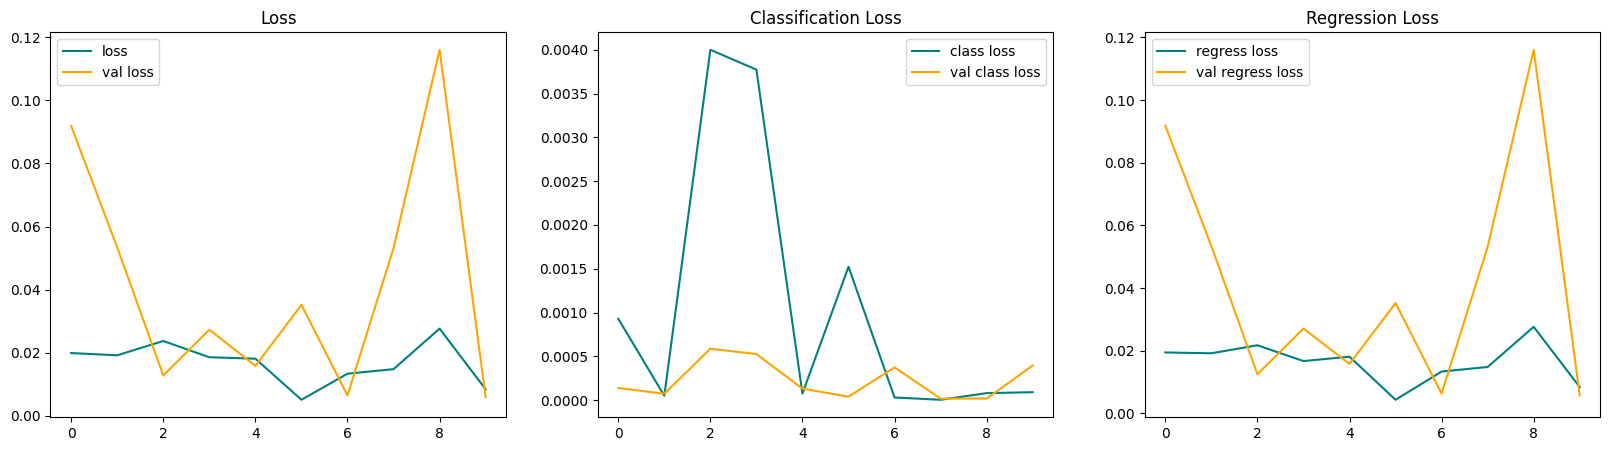

In [105]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [106]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


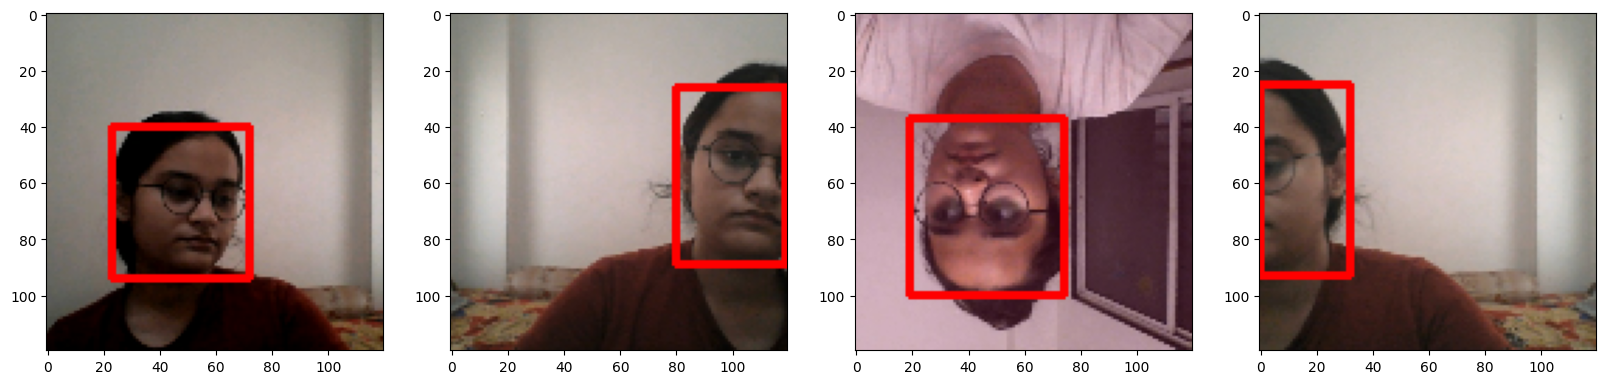

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [108]:
from tensorflow.keras.models import load_model

In [109]:
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [111]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 127ms/step


KeyboardInterrupt: 